In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import sympy as sp
 
dt = 0.0001   #s
t_ini = 0
t_fin = 30    #s
tiempo = np.arange(t_ini, t_fin, dt)

sqrtpi = np.sqrt(np.pi)
t_pstc = 0.01
def diracDelta(x):
    #la dirac delta devuelve entre  y = [0,1]
    return np.exp(-(x/t_pstc)**2)


class LIF:
    #Modelo LIF 
    riobase = 1.5e-9        #riobase de la neurona, no se usa mas que para la codificacion
    Rm = 10e6              #Resistencia de membrana 10MOhms (10e6)
    Cm = 1e-9               #Capacitancia de membrana 1nF (1e-9)
    tm = Rm * Cm         #constante temporal membrana 10ms [ms]
    El = -0.070             #voltaje de reposo  mV
    vth = -0.055            #voltaje de  umbral mV
    vspike = 0.020          #voltaje de disparo mV
    tref = 0.002            #periodo refractario 2ms
    def __init__(self):
        self.V = self.El      #iniciando con el coltaje de reposo
        self.Isyn = 0
        self.last_tf = 0        #ultimo tiempo de disparo = 0
        self.frec_hist = []
        self.firing_hist = []  #no hay disparo al inicio de la ejecuion
        self.Isyn_hist = []     #historial de la corriente de entrada a la neurona
        # self.Vm_hist = []

    def simulate(p, t, Isyn):
        if((t-p.last_tf)>=p.tref):                      #si no nos encontramos en el periodo refractario
            dV = (p.El - p.V + p.Rm * Isyn)/p.tm        #se integra la nueva corriente
        else:                                           #estamos en periodo refractario, Vm debe tender a El
            dV = dV = (p.El - p.V + p.Rm * 0)/p.tm      #en periodo refractario no se integra nueva corriente
        p.V = p.V + dt * dV                             

        if(p.V >= p.vth):                       #si el voltaje de membrana es superado
            p.V = p.El                      #se resetea el voltaje de membrana
            p.last_tf = t                       #se registra el tiempo de disparo
            p.firing_hist.append(t)             #agregando el nuevo tiempo de disparo
        elif(p.V<p.El):                     #se evita que el voltaje se vaya negativvo
            p.V = p.El
        p.Isyn_hist.append(Isyn)
        # p.Vm_hist.append(p.V)
        return p.vspike * diracDelta(t - p.last_tf)         #la salda es un impulso de amplitud maxima 20mV

class LIFConductance(LIF):
    Csyn = 1e-4         #Constante of injection current   https://doi.org/10.1016/j.neucom.2021.06.027
    tsyn = 0.010                #tiempo de decaimiento de la inyeccion de corriente
    def simulate(p, t,  Ewij_dd):
        dIsyn = (1/p.tsyn) * (-p.Isyn + p.Csyn * Ewij_dd)
        p.Isyn = p.Isyn + dt * dIsyn
        if((t-p.last_tf)>=p.tref):                      #si no nos encontramos en el periodo refractario
            dV = (p.El - p.V + p.Rm * p.Isyn)/p.tm        #se integra la nueva corriente
        else:                                           #estamos en periodo refractario, Vm debe tender a El
            dV = dV = (p.El - p.V + p.Rm * 0)/p.tm      #en periodo refractario no se integra nueva corriente
        p.V = p.V + dt * dV                             

        if(p.V >= p.vth):                       #si el voltaje de membrana es superado
            p.V = p.El                      #se resetea el voltaje de membrana
            p.last_tf = t                       #se registra el tiempo de disparo
            p.firing_hist.append(t)             #agregando el nuevo tiempo de disparo
        elif(p.V<p.El):                     #se evita que el voltaje se vaya negativvo
            p.V = p.El

        p.Isyn_hist.append(p.Isyn)
        # p.Vm_hist.append(p.V)
        return p.vspike * diracDelta(t - p.last_tf)

class RSTDP:
    #la entrada de corriente de la neurona est en nano amperes (1e-9), el voltaje de salida en mV (1e-3)
    #ya que R =1/G y v = IR,  v = I/G , o bien G = I/v  = 1e-9/1e-3 = 1e-6  (microsiemens)
    Ap = 1            #10 uS por spike
    Am = -Ap
    tE = 0.010          #milisegundos
    # wmax = 0.001          #1mS  max = 1kOhms
    # wmin = -wmax              
    def __init__(self, w_init, wmax, wmin):
        self.wmax = wmax
        self.wmin = wmin
        self.w = w_init
        self.E = 0             
        self.dE = 0
        self.w_hist = []
    
    def simulate(self, dd_prev, dd_post, R):
        Wpre =  self.Ap * dd_prev 
        Wpost = self.Am * dd_post
        dE = (-self.E/self.tE) + Wpre + Wpost
        self.E = self.E + dt * dE
        dw = R * self.E
        self.w = self.w + dt * dw
        if(self.w<self.wmin):
            self.w = self.wmin
        elif(self.w>self.wmax):
            self.w = self.wmax
        self.w_hist.append(self.w)
        return self.w

# class StepFowardEncoder:
#     def __init__(self,Ic,  thr):
#         self.base = 0
#         self.thr = thr
#         self.Ic = Ic
    
#     def encode(self, x):
#         IcP = 0
#         IcN = 0
#         base = self.base
#         thr = self.thr
#         if(x > (base + thr)):
#             IcP = self.Ic
#             base = base + thr
#         elif(x < (base - thr)):
#             IcN = self.Ic
#             base = base - thr
#         self.base = base
#         return IcP, IcN

class StepFowardEncoder:
    def __init__(self,Ic,  thr):
        self.base = 0
        self.thr = thr
        self.Ic = Ic
    
    def encode(self, x):
        alpha = np.tanh(x - self.base)
        IcP = (1+alpha) * self.Ic
        IcN = (1-alpha) * self.Ic
        self.base = self.base + self.thr * alpha
        return IcP, IcN

        

class SFDecoderModified:
    def __init__(self, thr):
        self.base = 0
        self.thr = thr
        self.out_hist = []

    def decode(self,t, spk_pos, spk_neg):
        self.base = self.base + self.thr * spk_pos - self.thr * spk_neg
        self.out_hist.append(self.base)
        return self.base

class Network:
    def __init__(self, n, m):
        self.n = n
        self.m = m
        self.j_layer = [LIF() for j in range(n)]
        self.k_layer = [LIFConductance() for k in range(m)]
        self.wjk = np.random.rand(n, m)/1000                        #inicializando pesos sinapticos de manera aleatoria, entre 0 y 0.001
        # self.wjk = np.zeros([n,m])
        self.synapses_jk = np.empty((n, m), dtype = object)         #creando un array de objetos tipo synapsis
        for (j,k), syn in np.ndenumerate(self.synapses_jk):          #inicializando cada objeto tipo sinapsis, con su valor inicial
            self.synapses_jk[j,k] = RSTDP(self.wjk[j,k], 1e-3, 0.1e-3)           
        self.Rjk = np.ones(m)                                       #vector REWARD, inicializado en 1

    def simulate(self, t, Ic_j):
        #Ic_j: vector de corriente,, proveniente de los encoders, para la capa j
        dd_j = []                                                   #obteniendo disparos capa j
        for j, neuron in enumerate(self.j_layer):
            dd = neuron.simulate(t,Ic_j[j])
            dd_j.append(dd)
        dd_j = np.array(dd_j)   
       
        dd_k = []                                                   #simulando disparos capa k
        Ic_k = np.dot(dd_j, self.wjk)
        for k, neuron in enumerate(self.k_layer):
            #dd = neuron.simulate(t,np.dot(self.wjk[:,k], dd_j))
            dd = neuron.simulate(t,Ic_k[k])
            dd_k.append(dd)
        dd_k = np.array(dd_k)
       
        for (j,k), syn in np.ndenumerate(self.synapses_jk):                     #actualizando sinapsis wjk
            self.wjk[j,k] = syn.simulate(dd_j[j],  dd_k[k], self.Rjk[k])        #guardando los pesos sinapticos  para la siguiente iteracion

        return dd_k                                                         #retornando los spikes de la ultima capa




x1 = sp.symbols('x_1')                                              #desarrollando series de taylor del atractor de lorenz (5 iteraciones)
Ax = sp.Matrix([[-10, 10, 0],[28, -1, -x1],[0, x1, -8/3]])

I = sp.eye(3)                                    
taylor = (I + (Ax * dt)/1 
           + (((Ax * dt)**2)/2) 
           + (((Ax * dt)**3)/6) 
           +  (((Ax * dt)**4)/24) 
           +  (((Ax * dt)**5)/120))

A_nonlinear = sp.lambdify(x1, Ax)
A_taylor = sp.lambdify(x1, taylor)                                        #aproximacion del sistema, con entradas de control cero
C = sp.Matrix([[1,0,0]])                                                  #matriz de salida del sistema
sig_x = 0.535612920393419                                                 #definiendo desviacion estandar de x
sig_y = 0.25375994265013957 #np.random.rand()#0.0                         #definiendo desviacion estandar de y
sig_z = 0.5271084217292544 #np.random.rand()#0.0                          #definiendo desviacion estandar de x
sig_x_ob = 0.3301155938699889 #np.random.rand()#0.0                       #definiendo desviacion estandar de x

xt = sp.Matrix([[5],[20],[-5]])
hxtt = sp.Matrix([[0],[0],[0]])
Kg = sp.zeros(3,1)

x1_hist = []
x2_hist = []
x3_hist = []

hx1_hist = []
hx2_hist = []
hx3_hist = []

SNNP = Network(4,3)
SNNN = Network(4,3)
Encoders = [StepFowardEncoder(1.5e-9, 0.00001) for i in range(4)]
Decoders = [SFDecoderModified(0.00001) for j in range(3)]
        
for t in tqdm(tiempo):

    wt = sp.Matrix([[np.random.normal(0, sig_x)],                   #creando ruido para las senales de la planta 
                    [np.random.normal(0, sig_y)],                   #este ruido no estará disponile para la red
                    [np.random.normal(0, sig_z)]])
    vt = sp.Matrix([[np.random.normal(0, sig_x_ob)]])                  #creando ruido para las senales de la planta a la salida
  

    dxt = A_nonlinear(xt[0,0]) * xt + wt                   #simulando la planta no lineal (ground truth) y agregandole ruido. 
    xt = xt + dt * dxt                                             #integrando euler
    yt = C * xt + vt                                                #obteniendo mediciones de la planta (ground truth) y agregandole ruido de medicion   
                                   
                                                                    #paso 1 prediccion del kalman filter
    hxtt1 = A_taylor(hxtt[0,0]) * hxtt                   #obteniendo estado predicho hxtt1
    hytt1 = C * hxtt1                                               #obteniendo salida estimada
    dhxt = hxtt - hxtt1                                             #calculando la diferencia entre lo predicho entre el paso anterior y la nueva prediccion
    dyt = yt - hytt1                                                #calculando la diferencia entre lo medido  y la nueva medicion predicha


    vector_input = [dhxt[0,0], dhxt[1,0], dhxt[2,0], dyt[0,0]]      #poniendo las senales de entrada de la red en un solo vector
    IcP_vector = []                                                 #Vector de corriente de exitacion para la capa j de la red SNNP
    IcN_vector = []                                                 #Vector de corriente de exitacion para la capa j de la red SNNN
    for j, encoder in enumerate(Encoders):                          #ciclo para iterar entre cada Encoder
        IcP, IcN = encoder.encode(np.float64(vector_input[j]))                  #codificando
        IcP_vector.append(IcP)                                      #agregando al vector de entrada correspondiente
        IcN_vector.append(IcN)
    
    
    dd_SNNP = SNNP.simulate(t, IcP_vector)                          #suministrando corriente de exitacion a la primer capa de la red SNNP, simulando salida 
    dd_SNNN = SNNN.simulate(t, IcN_vector)                          #suministrando corriente de exitacion a la primer capa de la red SNNN, simulando salida 
    
    for k, decoder in enumerate(Decoders):                          #iterando entre cada decoder para obtener la matriz de kalman
        Kg[k, 0] = decoder.decode(t, dd_SNNP[k], dd_SNNN[k])        #obteniendo nuevo componente de la matriz de kalman

    hxtt = hxtt1 + Kg * dyt                                         #obteniendo estimacion para el siguiente paso
    # dLdKt = 2 * (Kg * dyt - dhxt) * np.transpose(dyt)               #calculando el gradiente de la salida de la red
    # SNNP.Rjk = np.tanh(np.array(dLdKt).astype(np.float64))          #Asignando la senal de recompensa para la ultima  capa de la red SNNP                                    
    # SNNP.Rjk = np.tanh(np.array(dLdKt).astype(np.float64))          #Asignando la senal de recompensa para la ultima  capa de la red SNNN

    #guardandoo en historial
    x1_hist.append(xt[0,0])
    x2_hist.append(xt[1,0])
    x3_hist.append(xt[2,0])
    
    hx1_hist.append(hxtt[0,0])
    hx2_hist.append(hxtt[1,0])
    hx3_hist.append(hxtt[2,0])

    if(abs(hxtt[0,0]-xt[0,0]) > 200 or abs(hxtt[1,0]-xt[1,0]) > 200 or  abs(hxtt[2,0]-xt[2,0]) > 200):
        tiempo = np.arange(0, t + dt, dt)
        break



100%|██████████| 300000/300000 [1:06:14<00:00, 75.48it/s]


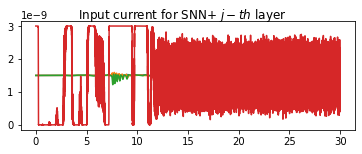

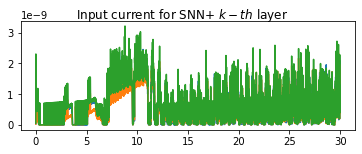

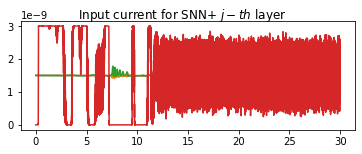

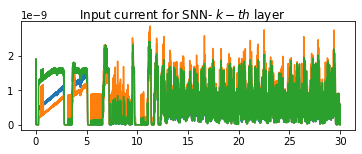

In [2]:


fig, ax = plt.subplots(1, figsize = (6,2))
for k,neuron in enumerate(SNNP.j_layer):
    ax.plot(tiempo[::5], neuron.Isyn_hist[::5], label = "SNNP j_layer")
# ax[0].legend()
# ax[1].legend()
fig.suptitle("Input current for SNN+ $j-th$ layer")
fig.savefig('InputCurrentSNNPjlayer.pdf')

fig, ax = plt.subplots(1, figsize = (6,2))
for k,neuron in enumerate(SNNP.k_layer):
    ax.plot(tiempo[::5], neuron.Isyn_hist[::5], label = "SNNP j_layer")
# ax[0].legend()
# ax[1].legend()
fig.suptitle("Input current for SNN+ $k-th$ layer")
fig.savefig('InputCurrentSNNPklayer.pdf')

fig, ax = plt.subplots(1, figsize = (6,2))
for k,neuron in enumerate(SNNN.j_layer):
    ax.plot(tiempo[::5], neuron.Isyn_hist[::5], label = "SNNP j_layer")
# ax[0].legend()
# ax[1].legend()
fig.suptitle("Input current for SNN+ $j-th$ layer")
fig.savefig('InputCurrentSNNNjlayer.pdf')


fig, ax = plt.subplots(1, figsize = (6,2))
for k,neuron in enumerate(SNNN.k_layer):
    ax.plot(tiempo[::5], neuron.Isyn_hist[::5], label = "SNNP j_layer")
# ax[0].legend()
# ax[1].legend()
fig.suptitle("Input current for SNN- $k-th$ layer")
fig.savefig('InputCurrentSNNNklayer.pdf')


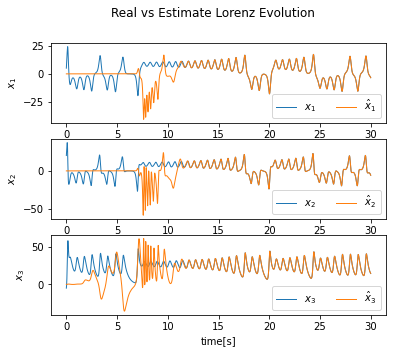

In [13]:
fig, ax = plt.subplots(3, figsize=(6, 5))
#ax = plt.axes(projection='3d')
ax[0].plot(tiempo[::5], x1_hist[::5],  label = "$x_1$", linewidth=1)
ax[1].plot(tiempo[::5], x2_hist[::5], label = "$x_2$", linewidth=1)
ax[2].plot(tiempo[::5], x3_hist[::5], label = "$x_3$", linewidth=1)

ax[0].plot(tiempo[::5], hx1_hist[::5], label = "$\hat x_1$", linewidth=1)
ax[1].plot(tiempo[::5], hx2_hist[::5], label = "$\hat x_2$", linewidth=1)
ax[2].plot(tiempo[::5], hx3_hist[::5], label = "$\hat x_3$", linewidth=1)
ax[0].legend(loc=4, ncol=2)
ax[1].legend(loc=4, ncol=2)
ax[2].legend(loc=4, ncol=2)
ax[0].set(xlabel = 'time[s]' , ylabel = '$x_1$')
ax[1].set(xlabel = 'time[s]' , ylabel = '$x_2$')
ax[2].set(xlabel = 'time[s]' , ylabel = '$x_3$')
fig.suptitle("Real vs Estimate Lorenz Evolution")
fig.savefig('LorenzStateEvolution.pdf')


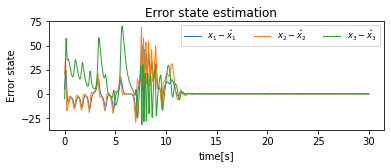

In [14]:

fig, ax = plt.subplots(1, figsize = (6,2))
ax.plot(tiempo[::5], np.array(x1_hist[::5])-np.array(hx1_hist[::5]), label = "$x_1-\hat x_1$", linewidth=1)
ax.plot(tiempo[::5], np.array(x2_hist[::5])-np.array(hx2_hist[::5]), label = "$x_2-\hat x_2$", linewidth=1)
ax.plot(tiempo[::5], np.array(x3_hist[::5])-np.array(hx3_hist[::5]), label = "$x_3-\hat x_3$", linewidth=1)
ax.set(xlabel = 'time[s]' , ylabel = 'Error state')
ax.legend(loc=1, ncol=3, fontsize="small")
fig.suptitle("Error state estimation")
fig.savefig('LorenzError.pdf')


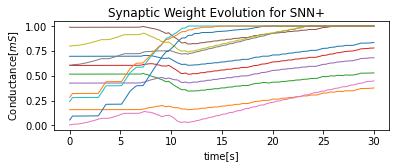

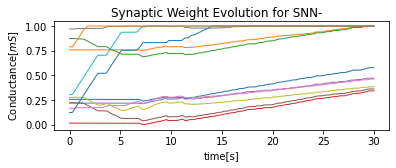

In [10]:

fig, ax = plt.subplots(1, figsize=(6, 2))
for (j,k), syn in np.ndenumerate(SNNP.synapses_jk):
    ax.plot(tiempo[::5], np.array(syn.w_hist[::5])*1000, linewidth=1)
fig.suptitle("Synaptic Weight Evolution for SNN+")
ax.set(xlabel = 'time[s]' , ylabel = 'Conductance[$mS$]')
fig.savefig('WeightEvSNNP.pdf')



fig, ax = plt.subplots(1, figsize=(6, 2))
for (j,k), syn in np.ndenumerate(SNNN.synapses_jk):
    ax.plot(tiempo[::5], np.array(syn.w_hist[::5])*1000, linewidth=1)
fig.suptitle("Synaptic Weight Evolution for SNN-")
ax.set(xlabel = 'time[s]' , ylabel = 'Conductance[$mS$]')
fig.savefig('WeightEvSNNN.pdf')


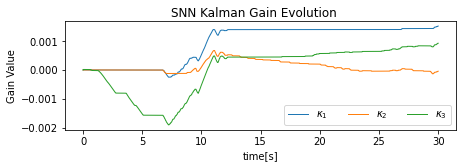

In [11]:
fig, ax = plt.subplots(1, figsize = (7, 2))
for k, decoder in enumerate(Decoders):
    ax.plot(tiempo[::5], decoder.out_hist[::5], label = "$\kappa_{}$".format(k+1), linewidth=1)
ax.legend(loc=4, ncol=3)
fig.suptitle("SNN Kalman Gain Evolution")
ax.set(xlabel = 'time[s]' , ylabel = 'Gain Value')
fig.savefig('KalmanGain.pdf')

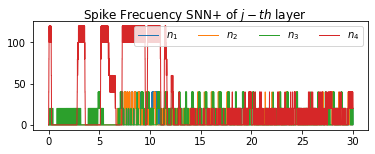

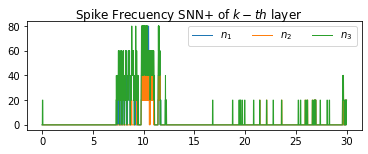

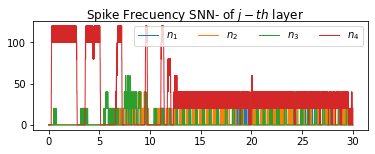

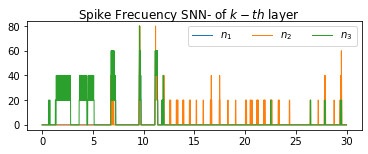

In [12]:

def frecuenciaDisaparo(T, timeline, spikes):
    frec_history = []
    for t in timeline:
        spikes_left = spikes[spikes < t]        #buscando los spikes dentro de la ventana T
        spikes_in = spikes_left[spikes_left >(t-T)]
        f = (len(spikes_in))  * (1/T)
        frec_history.append(f)
    return np.array(frec_history)

T = 0.05
fig, ax = plt.subplots(1, figsize=(6, 2))
for k,neuron in enumerate(SNNP.j_layer):
    frec_hist = frecuenciaDisaparo(T, tiempo, np.array(neuron.firing_hist))
    ax.plot(tiempo, frec_hist, label = "$n_{}$".format(k+1), linewidth=1)

ax.legend(loc = 1, ncol=4)
fig.suptitle("Spike Frecuency SNN+ of $j-th$ layer")
fig.savefig('SPKFRECSNNPjlayer.pdf')

fig, ax = plt.subplots(1, figsize=(6, 2))
for k,neuron in enumerate(SNNP.k_layer):
    frec_hist = frecuenciaDisaparo(T, tiempo, np.array(neuron.firing_hist))
    ax.plot(tiempo, frec_hist, label = "$n_{}$".format(k+1), linewidth=1)

ax.legend(ncol=3)
fig.suptitle("Spike Frecuency SNN+ of $k-th$ layer")
fig.savefig('SPKFRECSNNPklayer.pdf')


fig, ax = plt.subplots(1, figsize=(6, 2))
for k,neuron in enumerate(SNNN.j_layer):
    frec_hist = frecuenciaDisaparo(T, tiempo, np.array(neuron.firing_hist))
    ax.plot(tiempo, frec_hist, label = "$n_{}$".format(k+1), linewidth=1)

ax.legend(loc = 1,ncol=4)
fig.suptitle("Spike Frecuency SNN- of $j-th$ layer")
fig.savefig('SPKFRECSNNNjlayer.pdf')

fig, ax = plt.subplots(1, figsize=(6, 2))
for k,neuron in enumerate(SNNN.k_layer):
    frec_hist = frecuenciaDisaparo(T, tiempo, np.array(neuron.firing_hist))
    ax.plot(tiempo, frec_hist, label = "$n_{}$".format(k+1), linewidth=1)

ax.legend(ncol=3)
fig.suptitle("Spike Frecuency SNN- of $k-th$ layer")
fig.savefig('SPKFRECSNNNklayer.pdf')



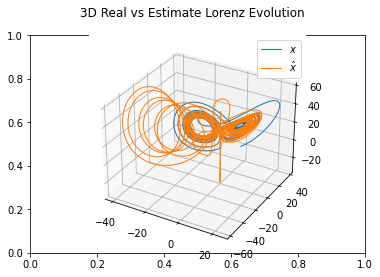

In [9]:

# fig, ax = plt.subplots(1)
# ax = plt.axes(projection='3d')
# ax.plot(x1_hist[::10],x2_hist[::10], x3_hist[::10] ,  label = "$x$", linewidth=1)
# ax.plot(hx1_hist[::10],hx2_hist[::10], hx3_hist[::10] ,  label = "$\hat x$", linewidth=1)
# ax.legend()
# fig.suptitle("3D Real vs Estimate Lorenz Evolution")
# fig.savefig('Lorenz3D.pdf')